<a href="https://colab.research.google.com/github/camelenchon/projetos/blob/main/teste_itau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Técnico – Coordenação de Clusterização**
### Desenvolver um modelo preditivo para identificar se um cliente que está com seus produtos de crédito em atraso irá renegociar sua dívida no mês seguinte.

#Importações e Configurações Inicial


In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
import numpy as np
import joblib #Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #utilizada para fazer o OneMatEncoding
from sklearn.metrics import (mean_squared_error, precision_score, recall_score,
                             f1_score, accuracy_score, roc_auc_score, confusion_matrix)  #metricas
from imblearn import under_sampling, over_sampling  # Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score #Utilizado para medir a acuracia do modelo preditivo

#Carregamento e Exploração de dados

In [209]:
#Carregamento da planilha
df = pd.read_csv('/content/drive/MyDrive/dados_clientes_case.csv')

In [210]:
#Explorando os dados

#Primeiras linhas
df.head()

,anomes_abt,id_cliente,nome,idade,tempo_de_conta_em_anos,segmento,att_vinculo_empregaticio,vinculo_empregaticio,salario_estimado,saldo_em_conta,reng_ult_3_meses,contato_ult_3meses,qtd_contratos_em_atraso,saldo_em_atraso,combo_produtos_em_atraso,maior_atraso,renegociou_no_mes_seguinte
0,202303,537139309,Yago Garcia,44,26,IA,0,Empregado,9625.148028,2665.266182,0,0,3,29435.495566,"VEICULO, IMOBILIARIO",67,1
1,202303,131542946,Paulo Ramos,60,42,IA,0,Desempregado,0.000000,49.881538,0,1,1,28760.080955,"CARTAO, IMOBILIARIO",48,0
2,202304,364174171,Paulo Araújo,45,27,IU,0,Empregado,18806.655134,7124.703715,1,0,5,15660.488152,"IMOBILIARIO, VEICULO",40,1
3,202302,917508336,Ana Carolina Ferreira,64,46,IA,0,Autônomo,21911.466804,26575.020468,0,0,2,19686.230575,CARTAO,66,0
4,202302,577175772,Anna Liz Ferreira,65,47,IA,1,Desempregado,NaN,932.363741,1,0,2,22483.299949,"IMOBILIARIO, VEICULO",50,0


In [211]:
#Informaçoes gerais sobre o DataFrame:

#Conjunto de dados
df.shape


(80000, 17)

In [212]:
#Visão gerao do conjunto de dados
df.head()

,anomes_abt,id_cliente,nome,idade,tempo_de_conta_em_anos,segmento,att_vinculo_empregaticio,vinculo_empregaticio,salario_estimado,saldo_em_conta,reng_ult_3_meses,contato_ult_3meses,qtd_contratos_em_atraso,saldo_em_atraso,combo_produtos_em_atraso,maior_atraso,renegociou_no_mes_seguinte
0,202303,537139309,Yago Garcia,44,26,IA,0,Empregado,9625.148028,2665.266182,0,0,3,29435.495566,"VEICULO, IMOBILIARIO",67,1
1,202303,131542946,Paulo Ramos,60,42,IA,0,Desempregado,0.000000,49.881538,0,1,1,28760.080955,"CARTAO, IMOBILIARIO",48,0
2,202304,364174171,Paulo Araújo,45,27,IU,0,Empregado,18806.655134,7124.703715,1,0,5,15660.488152,"IMOBILIARIO, VEICULO",40,1
3,202302,917508336,Ana Carolina Ferreira,64,46,IA,0,Autônomo,21911.466804,26575.020468,0,0,2,19686.230575,CARTAO,66,0
4,202302,577175772,Anna Liz Ferreira,65,47,IA,1,Desempregado,NaN,932.363741,1,0,2,22483.299949,"IMOBILIARIO, VEICULO",50,0


In [213]:
#Verifica os valores nulos
df.isnull().sum()

,0
anomes_abt,0
id_cliente,0
nome,0
idade,0
tempo_de_conta_em_anos,0
segmento,0
att_vinculo_empregaticio,0
vinculo_empregaticio,0
salario_estimado,8150
saldo_em_conta,5709


In [214]:
#Informações básicas
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   anomes_abt                  80000 non-null  int64  
 1   id_cliente                  80000 non-null  int64  
 2   nome                        80000 non-null  object 
 3   idade                       80000 non-null  int64  
 4   tempo_de_conta_em_anos      80000 non-null  int64  
 5   segmento                    80000 non-null  object 
 6   att_vinculo_empregaticio    80000 non-null  int64  
 7   vinculo_empregaticio        80000 non-null  object 
 8   salario_estimado            71850 non-null  float64
 9   saldo_em_conta              74291 non-null  float64
 10  reng_ult_3_meses            80000 non-null  int64  
 11  contato_ult_3meses          80000 non-null  int64  
 12  qtd_contratos_em_atraso     80000 non-null  int64  
 13  saldo_em_atraso             800

In [215]:
#Total de valores únicos de cada variável
valores_unicos = []
for i in df.columns[0:20].tolist():
  print(i, ':' ,len(df[i].astype(str).value_counts()))
  valores_unicos.append(len(df[i].astype(str).value_counts()))

anomes_abt : 6
id_cliente : 79997
nome : 38081
idade : 57
tempo_de_conta_em_anos : 57
segmento : 3
att_vinculo_empregaticio : 2
vinculo_empregaticio : 3
salario_estimado : 57490
saldo_em_conta : 74292
reng_ult_3_meses : 2
contato_ult_3meses : 2
qtd_contratos_em_atraso : 5
saldo_em_atraso : 80000
combo_produtos_em_atraso : 15
maior_atraso : 120
renegociou_no_mes_seguinte : 2


In [216]:
#Visualiza as medidas estatísticas
df.describe()

,anomes_abt,id_cliente,idade,tempo_de_conta_em_anos,att_vinculo_empregaticio,salario_estimado,saldo_em_conta,reng_ult_3_meses,contato_ult_3meses,qtd_contratos_em_atraso,saldo_em_atraso,maior_atraso,renegociou_no_mes_seguinte
count,80000.00000,8.000000e+04,80000.000000,80000.000000,80000.000000,71850.000000,74291.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,202303.50175,5.509725e+08,39.791375,21.794950,0.100237,10367.537275,3846.907754,0.228475,0.298875,2.995462,25568.309690,60.647850,0.280737
std,1.70873,2.599357e+08,14.845449,14.844907,0.300318,8789.516445,5280.353378,0.419853,0.457768,1.416348,14149.073295,34.717506,0.449362
min,202301.00000,1.000102e+08,16.000000,-1.000000,0.000000,0.000000,0.194118,0.000000,0.000000,1.000000,1000.073588,1.000000,0.000000
25%,202302.00000,3.262205e+08,28.000000,10.000000,0.000000,3063.193408,811.614323,0.000000,0.000000,2.000000,13321.450257,31.000000,0.000000
50%,202304.00000,5.517185e+08,34.000000,16.000000,0.000000,8362.889540,2003.665244,0.000000,0.000000,3.000000,25565.252453,61.000000,0.000000
75%,202305.00000,7.770601e+08,52.000000,34.000000,0.000000,17023.466017,4551.642700,0.000000,1.000000,4.000000,37841.761967,91.000000,1.000000
max,202306.00000,9.999934e+08,72.000000,55.000000,1.000000,31201.204326,32541.848277,1.000000,1.000000,5.000000,49999.470471,120.000000,1.000000


In [217]:
print('Maior saldo em atraso:', df['saldo_em_atraso'].max())
print('Menor saldo em atraso:', df['saldo_em_atraso'].min())

Maior saldo em atraso: 49999.470471193046
Menor saldo em atraso: 1000.0735878552624


In [218]:
df.groupby(['reng_ult_3_meses']).size()

,0
reng_ult_3_meses,
0,61722
1,18278


In [219]:
df.groupby(['qtd_contratos_em_atraso']).size()

,0
qtd_contratos_em_atraso,
1,16129
2,16036
3,15904
4,15931
5,16000


In [220]:
df.groupby(['contato_ult_3meses']).size()

,0
contato_ult_3meses,
0,56090
1,23910


In [221]:
df.groupby(['salario_estimado']).size()

,0
salario_estimado,
0.000000,14362
1926.028583,1
1928.190237,1
1941.607971,1
1967.773076,1
...,...
30889.736254,1
30904.268788,1
30908.734847,1


In [222]:
#Variavel alvo que precisa ser balanceada no pré-processamento
df.groupby(['renegociou_no_mes_seguinte']).size()

,0
renegociou_no_mes_seguinte,
0,57541
1,22459


#Análise exploratória dos dados

In [223]:
#Verifica os valores nulos
df.isnull().sum()

,0
anomes_abt,0
id_cliente,0
nome,0
idade,0
tempo_de_conta_em_anos,0
segmento,0
att_vinculo_empregaticio,0
vinculo_empregaticio,0
salario_estimado,8150
saldo_em_conta,5709


In [224]:
#Substitui os valores nulos de 'Salario Estimado' pela média dos valores
df['salario_estimado'] = df['salario_estimado'].fillna(df['salario_estimado'].mean())

In [225]:
#Substitui os valores nulos de 'Saldo em conta' pela média dos valores
df['saldo_em_conta'] = df['saldo_em_conta'].fillna(df['saldo_em_conta'].mean())

In [226]:
df.isnull().sum()

,0
anomes_abt,0
id_cliente,0
nome,0
idade,0
tempo_de_conta_em_anos,0
segmento,0
att_vinculo_empregaticio,0
vinculo_empregaticio,0
salario_estimado,0
saldo_em_conta,0


In [227]:
#Criando faixa de atraso para utilizar no modelo preditivo
bins = [-1, 30, 60, 90, 120]
labels = ['Até 30 dias', 'De 30 a 60 dias', 'De 60 a 90 dias', 'De 90 a 120 dias']
df['dias_atraso'] = pd.cut(df['maior_atraso'], bins=bins, labels=labels)
pd.value_counts(df.dias_atraso)

<ipython-input-227-23da3e8dfb3a>:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df.dias_atraso)


,count
dias_atraso,
De 90 a 120 dias,20189
De 60 a 90 dias,19986
De 30 a 60 dias,19929
Até 30 dias,19896


In [228]:
colunas = ['tempo_de_conta_em_anos', 'att_vinculo_empregaticio',
           'vinculo_empregaticio', 'salario_estimado', 'saldo_em_conta',
           'reng_ult_3_meses', 'contato_ult_3meses', 'qtd_contratos_em_atraso',
           'saldo_em_atraso', 'dias_atraso', 'renegociou_no_mes_seguinte']

df_dados = pd.DataFrame(df, columns=colunas)

In [229]:
df_dados.head(10)

,tempo_de_conta_em_anos,att_vinculo_empregaticio,vinculo_empregaticio,salario_estimado,saldo_em_conta,reng_ult_3_meses,contato_ult_3meses,qtd_contratos_em_atraso,saldo_em_atraso,dias_atraso,renegociou_no_mes_seguinte
0,26,0,Empregado,9625.148028,2665.266182,0,0,3,29435.495566,De 60 a 90 dias,1
1,42,0,Desempregado,0.000000,49.881538,0,1,1,28760.080955,De 30 a 60 dias,0
2,27,0,Empregado,18806.655134,7124.703715,1,0,5,15660.488152,De 30 a 60 dias,1
3,46,0,Autônomo,21911.466804,26575.020468,0,0,2,19686.230575,De 60 a 90 dias,0
4,47,1,Desempregado,10367.537275,932.363741,1,0,2,22483.299949,De 30 a 60 dias,0
5,51,0,Autônomo,10515.067881,1006.995073,0,0,4,15750.722936,De 60 a 90 dias,0
6,2,0,Desempregado,0.000000,966.716329,0,1,1,43291.304418,De 30 a 60 dias,0
7,29,1,Desempregado,10367.537275,393.686641,0,0,3,38764.052682,De 60 a 90 dias,0
8,19,0,Desempregado,0.000000,933.096445,0,1,4,34490.570575,Até 30 dias,0
9,21,0,Empregado,25823.709557,8442.032848,0,0,1,15199.356461,De 60 a 90 dias,0


In [230]:
df_dados.shape

(80000, 11)

In [231]:
df_dados.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tempo_de_conta_em_anos      80000 non-null  int64   
 1   att_vinculo_empregaticio    80000 non-null  int64   
 2   vinculo_empregaticio        80000 non-null  object  
 3   salario_estimado            80000 non-null  float64 
 4   saldo_em_conta              80000 non-null  float64 
 5   reng_ult_3_meses            80000 non-null  int64   
 6   contato_ult_3meses          80000 non-null  int64   
 7   qtd_contratos_em_atraso     80000 non-null  int64   
 8   saldo_em_atraso             80000 non-null  float64 
 9   dias_atraso                 80000 non-null  category
 10  renegociou_no_mes_seguinte  80000 non-null  int64   
dtypes: category(1), float64(3), int64(6), object(1)
memory usage: 6.2+ MB


In [232]:
df_dados.isnull().sum()

,0
tempo_de_conta_em_anos,0
att_vinculo_empregaticio,0
vinculo_empregaticio,0
salario_estimado,0
saldo_em_conta,0
reng_ult_3_meses,0
contato_ult_3meses,0
qtd_contratos_em_atraso,0
saldo_em_atraso,0
dias_atraso,0


#Analise exploratórias - variáveis categóricas

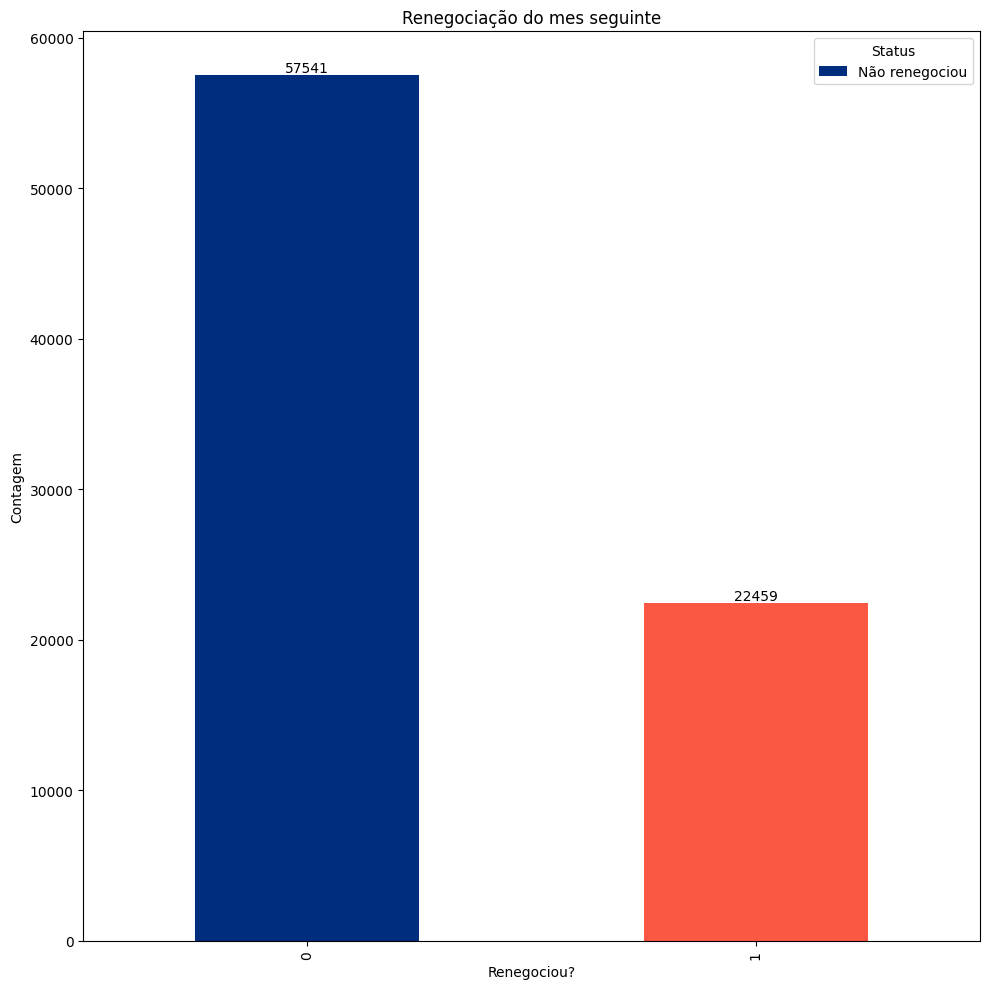

In [233]:
#Analisando a variavel alvo
ax = df_dados.renegociou_no_mes_seguinte.value_counts().plot(
    kind='bar',
    title='Renegociação do mes seguinte',
    color= ['#002d7e', '#fb5843'])
ax.set_xlabel('Renegociou?')
ax.set_ylabel('Contagem')
plt.legend(['Não renegociou', 'Renegociou'], title='Status')
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom'
    )
plt.show()

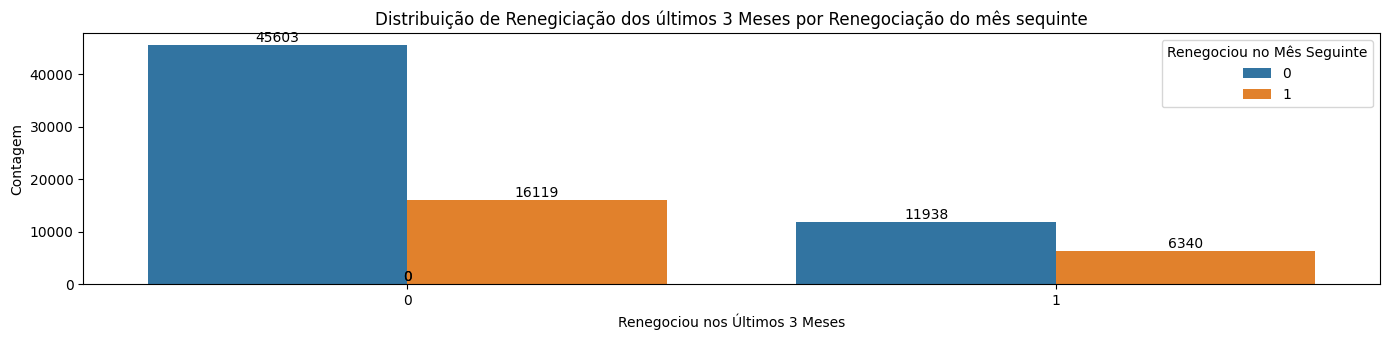

In [234]:
#Analise de reng_ult_3_meses com renegociou_no_mes_seguinte
plt.rcParams["figure.figsize"] = [14.00, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(data = df_dados, x = "reng_ult_3_meses", hue ="renegociou_no_mes_seguinte" )
ax.set_xlabel('Renegociou nos Últimos 3 Meses')
ax.set_ylabel('Contagem')
plt.legend(title='Renegociou no Mês Seguinte')
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom'
    )
plt.title('Distribuição de Renegiciação dos últimos 3 Meses por Renegociação do mês sequinte')
plt.show()

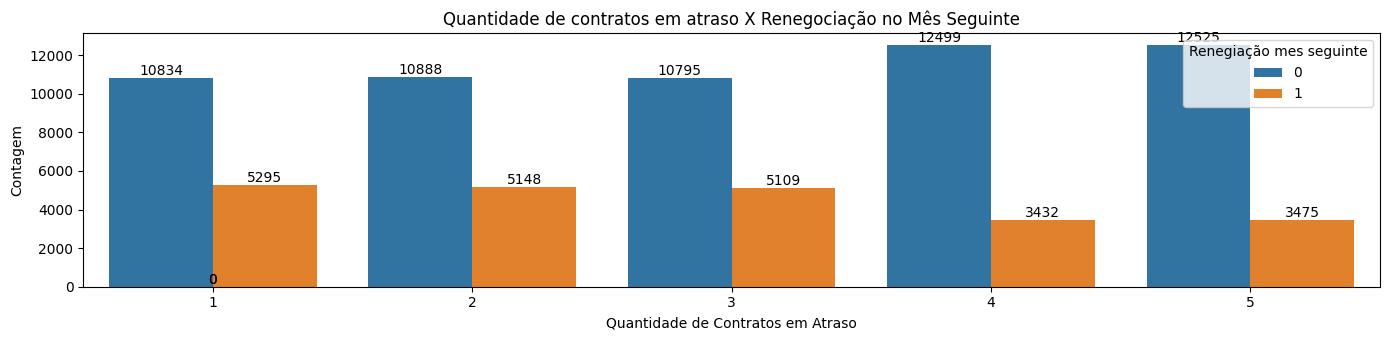

In [235]:
# Analise de qtd_contratos_em_atraso x renegociou_no_mes_seguinte
plt.rcParams["figure.figsize"] = [14.00, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(data = df_dados, x = "qtd_contratos_em_atraso", hue ="renegociou_no_mes_seguinte" )
ax.set_xlabel('Quantidade de Contratos em Atraso')
ax.set_ylabel('Contagem')
plt.legend(title='Renegiação mes seguinte')
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom'
    )
plt.title('Quantidade de contratos em atraso X Renegociação no Mês Seguinte')
plt.show()

#Análise exploratória das variáveis númericas

In [236]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tempo_de_conta_em_anos      80000 non-null  int64   
 1   att_vinculo_empregaticio    80000 non-null  int64   
 2   vinculo_empregaticio        80000 non-null  object  
 3   salario_estimado            80000 non-null  float64 
 4   saldo_em_conta              80000 non-null  float64 
 5   reng_ult_3_meses            80000 non-null  int64   
 6   contato_ult_3meses          80000 non-null  int64   
 7   qtd_contratos_em_atraso     80000 non-null  int64   
 8   saldo_em_atraso             80000 non-null  float64 
 9   dias_atraso                 80000 non-null  category
 10  renegociou_no_mes_seguinte  80000 non-null  int64   
dtypes: category(1), float64(3), int64(6), object(1)
memory usage: 6.2+ MB


In [237]:
# Carregar valores numericas para plot
variaveis_numericas = []
for i in df_dados.columns[0:11].tolist():
  if df_dados.dtypes[i] == 'int64' or df_dados.dtypes[i] == 'float64':
    variaveis_numericas.append(i)

In [238]:
variaveis_numericas

['tempo_de_conta_em_anos',
 'att_vinculo_empregaticio',
 'salario_estimado',
 'saldo_em_conta',
 'reng_ult_3_meses',
 'contato_ult_3meses',
 'qtd_contratos_em_atraso',
 'saldo_em_atraso',
 'renegociou_no_mes_seguinte']

In [239]:
#Quantidade de váriaveis
len(variaveis_numericas)

9

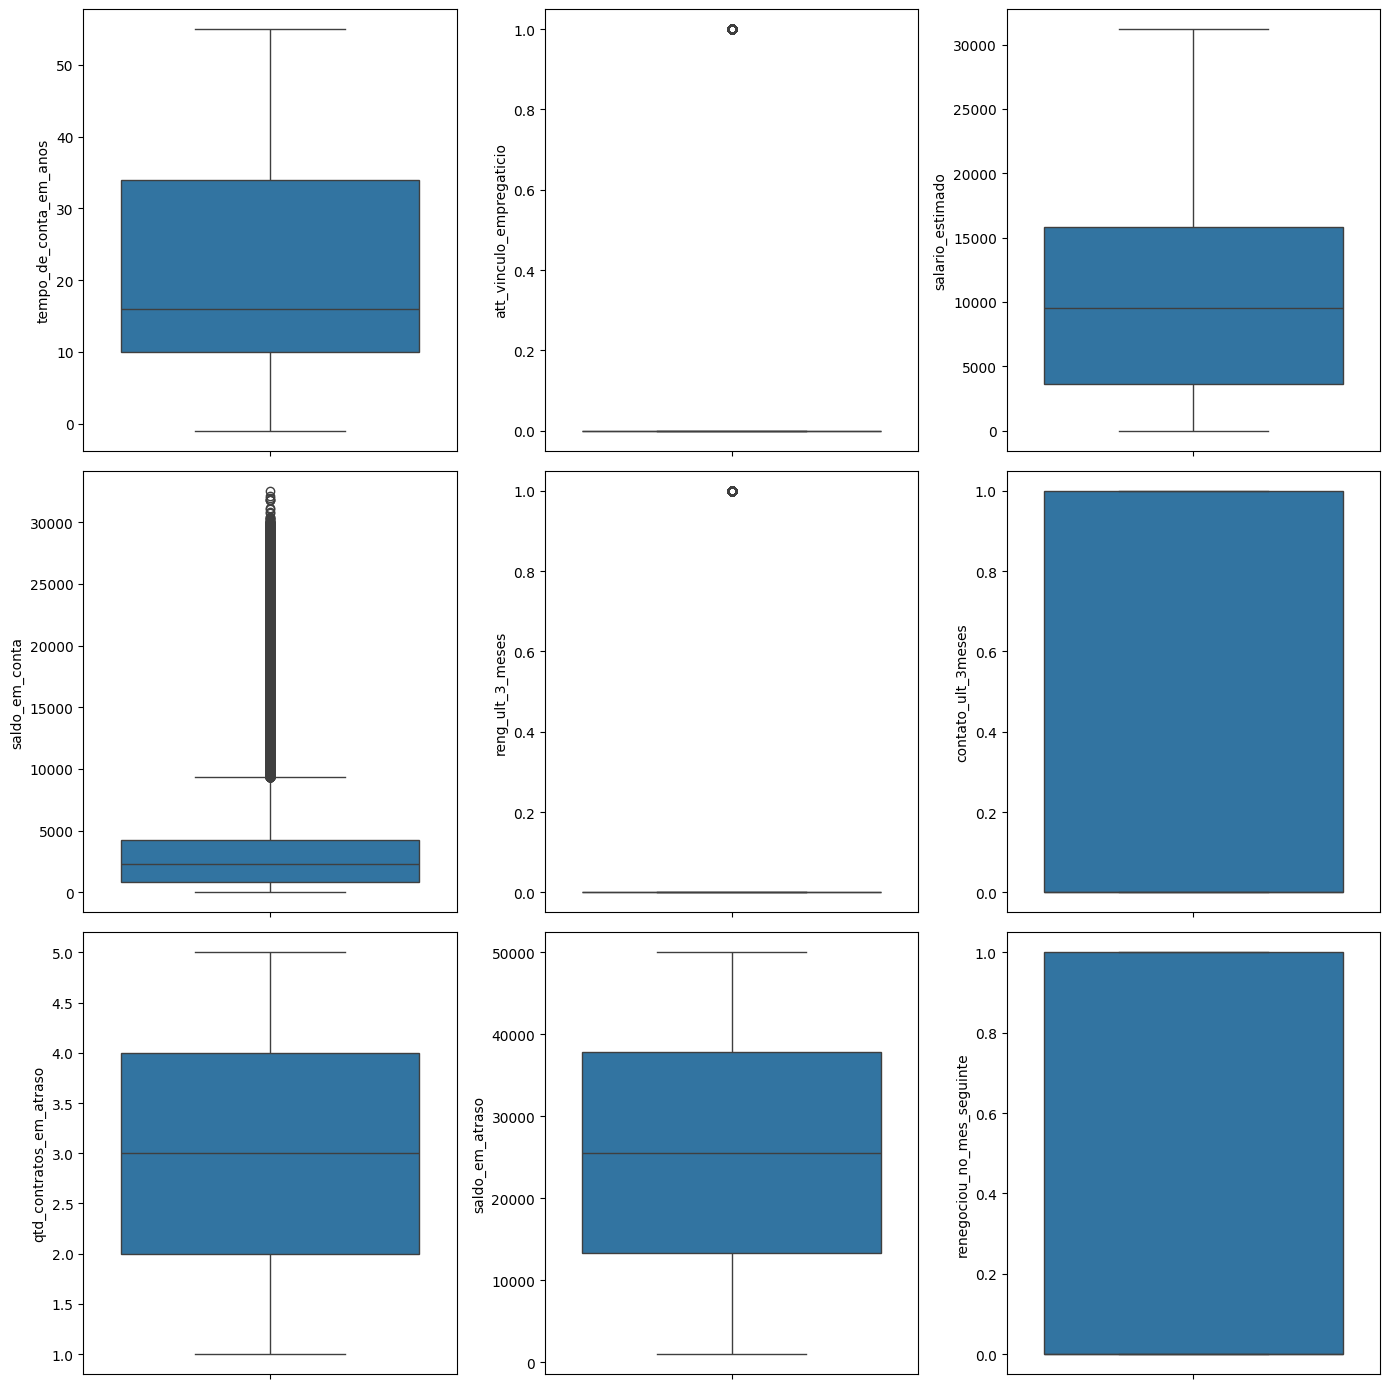

In [240]:
#Boxplot

plt.rcParams["figure.figsize"] = [14.00, 14.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(3,3) #3 linhas, 3 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_dados, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna ==3:
      linha += 1
      coluna = 0

plt.show()

In [241]:
#Carregar variaveis categoricas para OneHotEncoding
variaveis_categoricas = []
for i in df_dados.columns[0:10].tolist():
  if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':
    variaveis_categoricas.append(i)

In [242]:
variaveis_categoricas

['vinculo_empregaticio', 'dias_atraso']

In [243]:
#Cria o encoder e aplica o OneHotEncoder - transforma a variavel que esta em object e category em número
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])

In [244]:
df_dados.head()

,tempo_de_conta_em_anos,att_vinculo_empregaticio,vinculo_empregaticio,salario_estimado,saldo_em_conta,reng_ult_3_meses,contato_ult_3meses,qtd_contratos_em_atraso,saldo_em_atraso,dias_atraso,renegociou_no_mes_seguinte
0,26,0,2,9625.148028,2665.266182,0,0,3,29435.495566,2,1
1,42,0,1,0.000000,49.881538,0,1,1,28760.080955,1,0
2,27,0,2,18806.655134,7124.703715,1,0,5,15660.488152,1,1
3,46,0,0,21911.466804,26575.020468,0,0,2,19686.230575,2,0
4,47,1,1,10367.537275,932.363741,1,0,2,22483.299949,1,0


In [245]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tempo_de_conta_em_anos      80000 non-null  int64  
 1   att_vinculo_empregaticio    80000 non-null  int64  
 2   vinculo_empregaticio        80000 non-null  int64  
 3   salario_estimado            80000 non-null  float64
 4   saldo_em_conta              80000 non-null  float64
 5   reng_ult_3_meses            80000 non-null  int64  
 6   contato_ult_3meses          80000 non-null  int64  
 7   qtd_contratos_em_atraso     80000 non-null  int64  
 8   saldo_em_atraso             80000 non-null  float64
 9   dias_atraso                 80000 non-null  int64  
 10  renegociou_no_mes_seguinte  80000 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 6.7 MB


In [246]:
#Visualizar a quantidade de variavel target(alvo) para o balanceamento
variavel_target = df_dados.renegociou_no_mes_seguinte.value_counts()
variavel_target

,count
renegociou_no_mes_seguinte,
0,57541
1,22459


In [247]:
#Separar as variaveis preditoras e alvo
PREDITORAS = df_dados.iloc[:, 0:9]
TARGET = df_dados.iloc[:, 10]

In [248]:
#Visualizar as variaveis preditoras
PREDITORAS.head()

,tempo_de_conta_em_anos,att_vinculo_empregaticio,vinculo_empregaticio,salario_estimado,saldo_em_conta,reng_ult_3_meses,contato_ult_3meses,qtd_contratos_em_atraso,saldo_em_atraso
0,26,0,2,9625.148028,2665.266182,0,0,3,29435.495566
1,42,0,1,0.000000,49.881538,0,1,1,28760.080955
2,27,0,2,18806.655134,7124.703715,1,0,5,15660.488152
3,46,0,0,21911.466804,26575.020468,0,0,2,19686.230575
4,47,1,1,10367.537275,932.363741,1,0,2,22483.299949


In [249]:
#Visualizar as variaveis alvo
TARGET.head()

,renegociou_no_mes_seguinte
0,1
1,0
2,1
3,0
4,0


In [250]:
#Seed para reproduzir o mesmo resultado
seed = 100

#Criar o balenceador SMOTE
balanceador = SMOTE(random_state = seed)

#Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS,TARGET)

<Axes: title={'center': 'Renegociação do mes seguinte'}, xlabel='renegociou_no_mes_seguinte'>

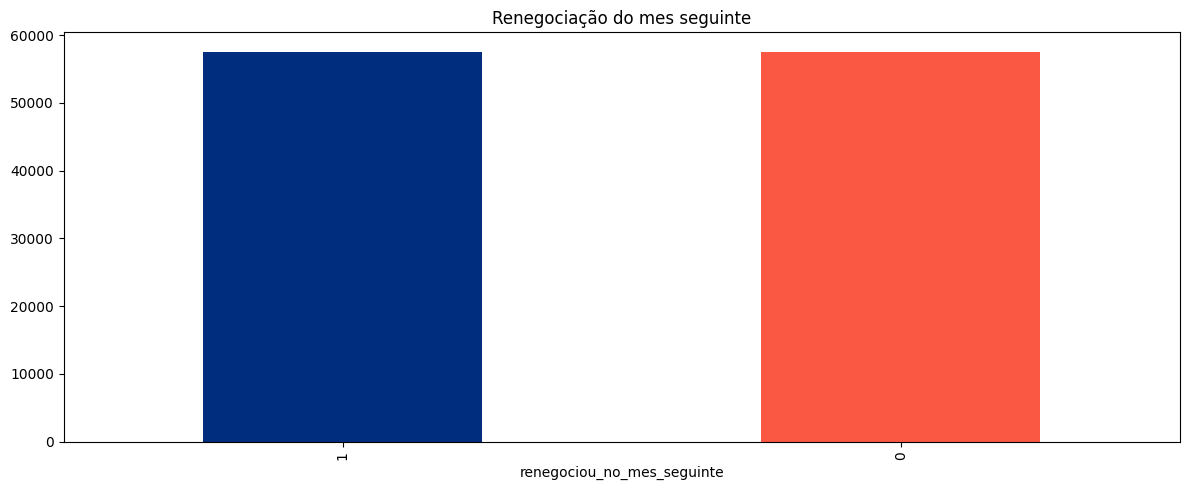

In [251]:
#Visualizando o balanceamento da variavel TARGET
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Renegociação do mes seguinte', color= ['#002d7e', '#fb5843'])

In [252]:
#Quantidade de registros antes do balanceamento
PREDITORAS.shape

(80000, 9)

In [253]:
#Quantidade de registros antes do balanceamento
TARGET.shape

(80000,)

In [254]:
#Quantidade de registros após do balanceamento
PREDITORAS_RES.shape

(115082, 9)

In [255]:
#Quantidade de registros após do balanceamento
TARGET_RES.shape

(115082,)

#Divisão dos dados e Treinamento e teste



In [259]:
# Divisão os dados em conjuntos de treino e teste: 'X_treino' e 'y_treino' para treinamento, e 'X_teste' e 'y_teste' para teste,
# utilizando 30% dos dados para teste e garantindo reprodutibilidade com um valor fixo de 'random_state' de 42.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size=0.3, random_state = 42)

In [260]:
#Normalizando as variaveis - Pré processamento dos Dados
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.fit_transform(X_teste)

In [261]:
#Visualizar a dimensão dos dados de treino
X_treino_normalizados.shape

(80557, 9)

In [262]:
#Visualizar os dados de treino normalizados
X_treino_normalizados

array([[0.30357143, 0.        , 1.        , ..., 0.        , 0.25      ,
        0.11839436],
       [0.21428571, 0.        , 1.        , ..., 0.        , 0.5       ,
        0.92174208],
       [0.21428571, 0.        , 1.        , ..., 0.        , 0.75      ,
        0.98663686],
       ...,
       [0.375     , 0.        , 1.        , ..., 0.        , 0.5       ,
        0.48702954],
       [0.26785714, 0.        , 0.5       , ..., 0.        , 0.25      ,
        0.07628715],
       [0.71428571, 0.        , 1.        , ..., 1.        , 0.        ,
        0.78971031]])

In [263]:
#Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators = 100)

#Construçao de modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

In [264]:
#Veriricando a acuracia do modelo com dados de teste
scores = clf.score(X_teste_normalizados, Y_teste)
scores

0.7546125995655322

Text(0.5, 1.0, 'Importancia de cada variavel')

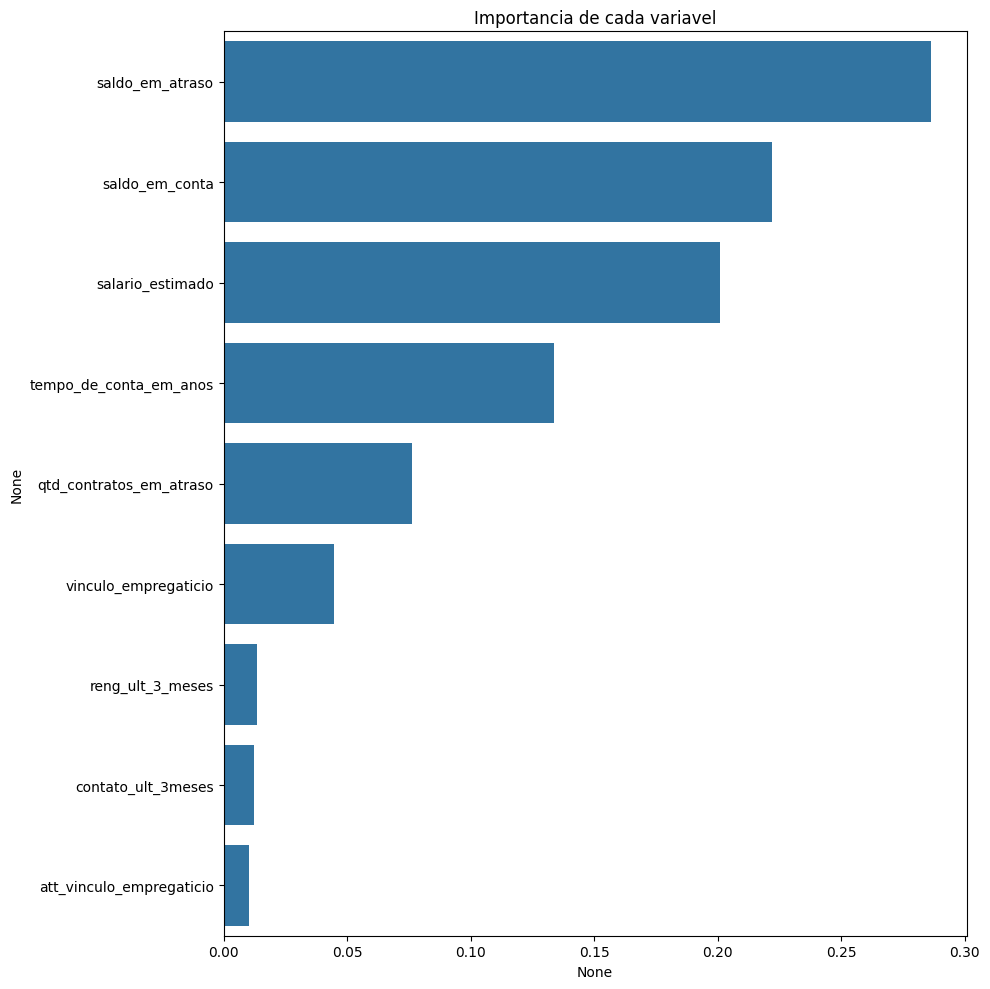

In [265]:
#Exibindo a importancia de cada viariavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importancia de cada variavel')

In [266]:
importances.sort_values(ascending = False)

,0
saldo_em_atraso,0.286474
saldo_em_conta,0.221916
salario_estimado,0.201007
tempo_de_conta_em_anos,0.133833
qtd_contratos_em_atraso,0.076162
vinculo_empregaticio,0.044846
reng_ult_3_meses,0.013404
contato_ult_3meses,0.012165
att_vinculo_empregaticio,0.010193


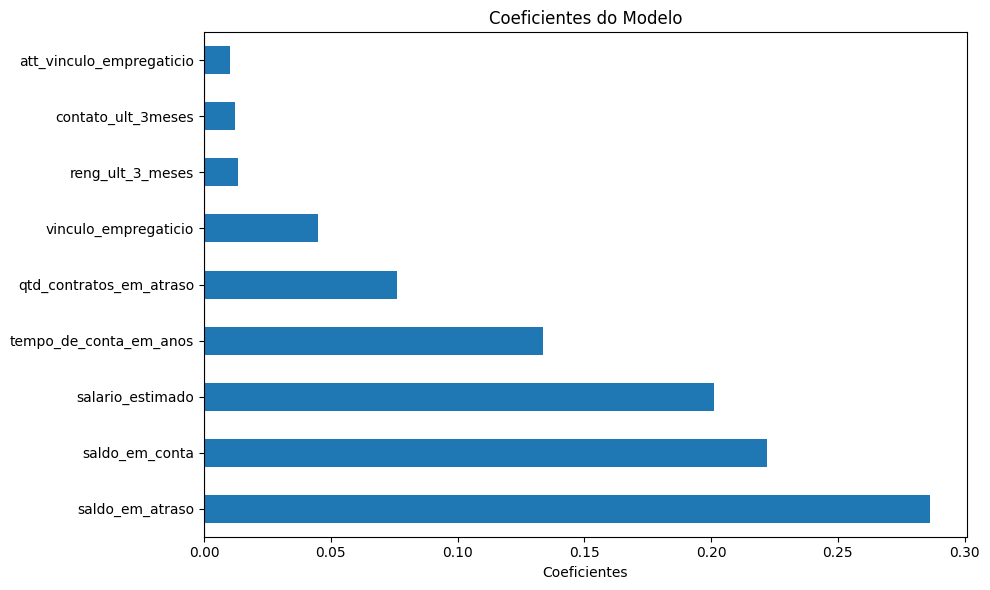

In [269]:
importances.plot.barh(figsize=(10,6))
plt.axvline(x=0, color='red')
plt.xlabel("Coeficientes")
plt.title("Coeficientes do Modelo")
plt.show()

In [ ]:
#Salvando o modelo criado e treinado
joblib.dump(clf, 'modelo_preditivo.pkl')

#Preparar os testes


In [ ]:
#Carregar o modelo treinado
clf = joblib.load('modelo_preditivo.pkl')

In [ ]:
#importar os dados
df = pd.read_csv('/content/drive/MyDrive/dados_clientes_case.csv')

In [270]:
#Substitui os valores nulos de 'Salario Estimado' pela média dos valores
df['salario_estimado'] = df['salario_estimado'].fillna(df['salario_estimado'].mean())

#Substitui os valores nulos de 'Saldo em conta' pela média dos valores
df['saldo_em_conta'] = df['saldo_em_conta'].fillna(df['saldo_em_conta'].mean())

#Criando faixa de atraso para utilizar no modelo preditivo
bins = [-1, 30, 60, 90, 120]
labels = ['Até 30 dias', 'De 30 a 60 dias', 'De 60 a 90 dias', 'De 90 a 120 dias']
df['dias_atraso'] = pd.cut(df['maior_atraso'], bins=bins, labels=labels)
pd.value_counts(df.dias_atraso)

colunas = ['tempo_de_conta_em_anos', 'att_vinculo_empregaticio',
           'vinculo_empregaticio', 'salario_estimado', 'saldo_em_conta',
           'reng_ult_3_meses', 'contato_ult_3meses', 'qtd_contratos_em_atraso',
           'saldo_em_atraso', 'dias_atraso', 'renegociou_no_mes_seguinte']

df_dados = pd.DataFrame(df, columns=colunas)

#Carregar variaveis categoricas para OneHotEncoding
variaveis_categoricas = []
for i in df_dados.columns[0:10].tolist():
  if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':
    variaveis_categoricas.append(i)

lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])

#Separar as variaveis preditoras e alvo
PREDITORAS = df_dados.iloc[:, 0:9]

#Normalizando as variaveis
Normalizador = MinMaxScaler()
dados_normalizados = Normalizador.fit_transform(PREDITORAS)

previsoes = clf.predict(dados_normalizados)
probabilidades = clf.predict_proba(dados_normalizados)
df['PREVISOES'] = previsoes
df['PROBABILIDADES'] = probabilidades[:, 1]
df.head(10)

<ipython-input-270-3c1513c377d2>:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df.dias_atraso)


,anomes_abt,id_cliente,nome,idade,tempo_de_conta_em_anos,segmento,att_vinculo_empregaticio,vinculo_empregaticio,salario_estimado,saldo_em_conta,reng_ult_3_meses,contato_ult_3meses,qtd_contratos_em_atraso,saldo_em_atraso,combo_produtos_em_atraso,maior_atraso,renegociou_no_mes_seguinte,dias_atraso,PREVISOES,PROBABILIDADES
0,202303,537139309,Yago Garcia,44,26,IA,0,Empregado,9625.148028,2665.266182,0,0,3,29435.495566,"VEICULO, IMOBILIARIO",67,1,De 60 a 90 dias,1,0.72
1,202303,131542946,Paulo Ramos,60,42,IA,0,Desempregado,0.000000,49.881538,0,1,1,28760.080955,"CARTAO, IMOBILIARIO",48,0,De 30 a 60 dias,0,0.07
2,202304,364174171,Paulo Araújo,45,27,IU,0,Empregado,18806.655134,7124.703715,1,0,5,15660.488152,"IMOBILIARIO, VEICULO",40,1,De 30 a 60 dias,1,0.87
3,202302,917508336,Ana Carolina Ferreira,64,46,IA,0,Autônomo,21911.466804,26575.020468,0,0,2,19686.230575,CARTAO,66,0,De 60 a 90 dias,1,0.94
4,202302,577175772,Anna Liz Ferreira,65,47,IA,1,Desempregado,10367.537275,932.363741,1,0,2,22483.299949,"IMOBILIARIO, VEICULO",50,0,De 30 a 60 dias,0,0.06
5,202303,356209196,Arthur Miguel Gonçalves,69,51,IU,0,Autônomo,10515.067881,1006.995073,0,0,4,15750.722936,"IMOBILIARIO, VEICULO",85,0,De 60 a 90 dias,0,0.00
6,202305,837058389,Catarina da Conceição,20,2,IA,0,Desempregado,0.000000,966.716329,0,1,1,43291.304418,"CARTAO, IMOBILIARIO",57,0,De 30 a 60 dias,0,0.04
7,202305,507903732,Diogo Rezende,47,29,IA,1,Desempregado,10367.537275,393.686641,0,0,3,38764.052682,"IMOBILIARIO, CARTAO, VEICULO",62,0,De 60 a 90 dias,0,0.01
8,202306,133473062,Rhavi Araújo,37,19,IP,0,Desempregado,0.000000,933.096445,0,1,4,34490.570575,"VEICULO, IMOBILIARIO, CARTAO",7,0,Até 30 dias,0,0.03
9,202305,890503688,Davi Miguel Leão,39,21,IP,0,Empregado,25823.709557,8442.032848,0,0,1,15199.356461,VEICULO,62,0,De 60 a 90 dias,0,0.23
